In [ ]:
from alphadia.calibration.property import calibration_model_provider, Calibration
from alphadia.workflow.managers.calibration_manager import CalibrationManager
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calibration Models
By default, alphaDIA comes with different calibration models all provided by the `calibration.calibration_model_provider`.
We can print the model provider to see what models are available.

In [ ]:
calibration_model_provider

<CalibrationModelProvider, 
[
 	 LinearRegression: <class 'sklearn.linear_model._base.LinearRegression'>
 	 LOESSRegression: <class 'alphabase.statistics.regression.LOESSRegression'>
 	 PolynomialRegression: <function PolynomialRegression at 0x1581499d0>
]>

# Calibrating a Single Property

Text(0, 0.5, 'mz_observed - mz_library')

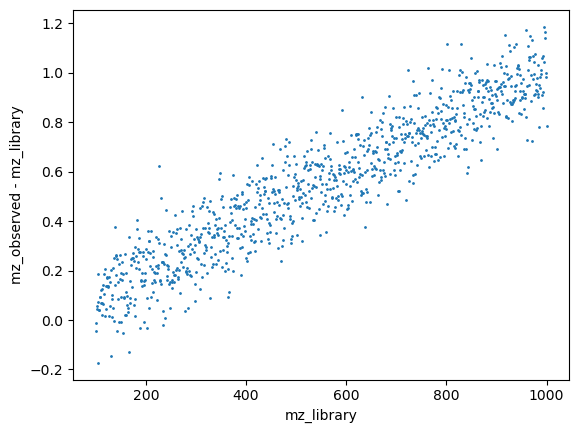

In [ ]:
mz_library = np.linspace(100, 1000, 1000)
mz_observed = mz_library + np.random.normal(0, 0.1, 1000) + mz_library * 0.001
mz_df = pd.DataFrame({"mz_library": mz_library, "mz_observed": mz_observed})

# We will calculate the difference between the observed and library mz values only for plotting purposes
mz_residual = mz_df["mz_observed"] - mz_df["mz_library"]
plt.scatter(mz_df["mz_library"], mz_residual, s=1)
plt.xlabel("mz_library")
plt.ylabel("mz_observed - mz_library")

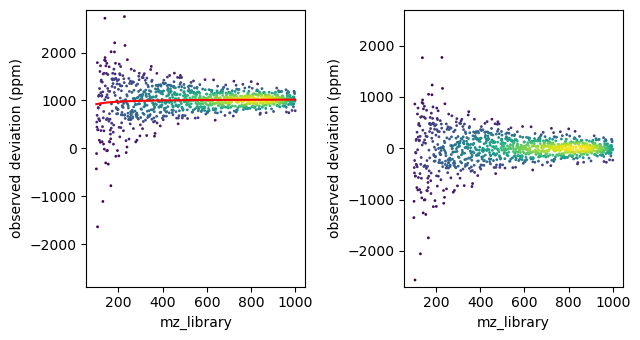

In [ ]:
# we will use a scikit-learn model to calibrate the mz values
from sklearn.linear_model import LinearRegression

# We will use a linear regression model to calibrate the mz values
mz_calibration = Calibration(
    name="mz_calibration",
    model=LinearRegression(),
    input_columns=["mz_library"],
    target_columns=["mz_observed"],
    output_columns=["mz_calibrated"],
    transform_deviation=1e6,
)

# The model is then fit to the data
mz_calibration.fit(mz_df, plot=True)

In [ ]:
# The model can then be used to predict the calibrated mz values
# This happens in place by default
mz_calibration.predict(mz_df)
print(mz_df.head())

   mz_library  mz_observed  mz_calibrated
0  100.000000    99.957007     100.092184
1  100.900901   100.889732     100.994010
2  101.801802   101.857610     101.895836
3  102.702703   102.748307     102.797662
4  103.603604   103.674902     103.699487


In [ ]:
# We can also get the 99% percentile error of the model
# It will return an numpy array with an element for every input column
print(mz_calibration.ci(mz_df, 0.95))

688.2224010220616


In [ ]:
import tempfile
import os

path = os.path.join(tempfile.tempdir, "mz_calibration.pkl")
mz_calibration.save(path)

mz_calibration_loaded = Calibration.from_file(path)
mz_calibration_loaded.predict(mz_df)
print(mz_df.head())

   mz_library  mz_observed  mz_calibrated
0  100.000000    99.957007     100.092184
1  100.900901   100.889732     100.994010
2  101.801802   101.857610     101.895836
3  102.702703   102.748307     102.797662
4  103.603604   103.674902     103.699487


# Calibrating a Single Property using Multiple Inputs

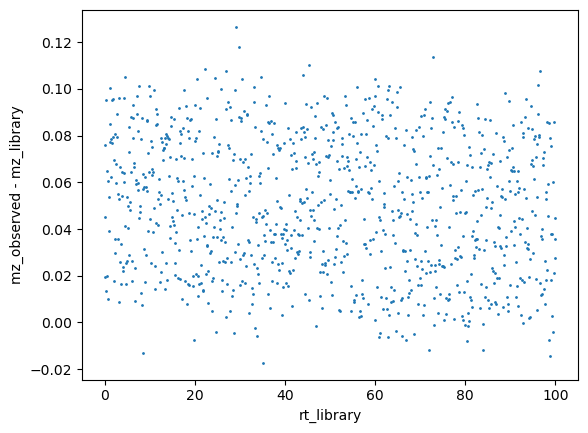

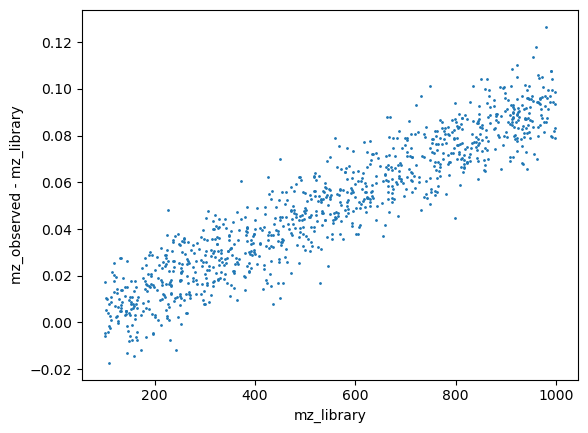

In [ ]:
rt_library = np.linspace(0, 100, 1000)
mz_library = np.random.uniform(100, 1000, 1000)
mz_observed = (
    mz_library
    + np.random.normal(0, 0.01, 1000)
    + mz_library * 0.0001
    - rt_library * 0.0001
)
mz_df = pd.DataFrame(
    {"rt_library": rt_library, "mz_library": mz_library, "mz_observed": mz_observed}
)

mz_residual = mz_df["mz_observed"] - mz_df["mz_library"]
plt.scatter(mz_df["rt_library"], mz_residual, s=1)
plt.xlabel("rt_library")
plt.ylabel("mz_observed - mz_library")
plt.show()

plt.scatter(mz_df["mz_library"], mz_residual, s=1)
plt.xlabel("mz_library")
plt.ylabel("mz_observed - mz_library")
plt.show()

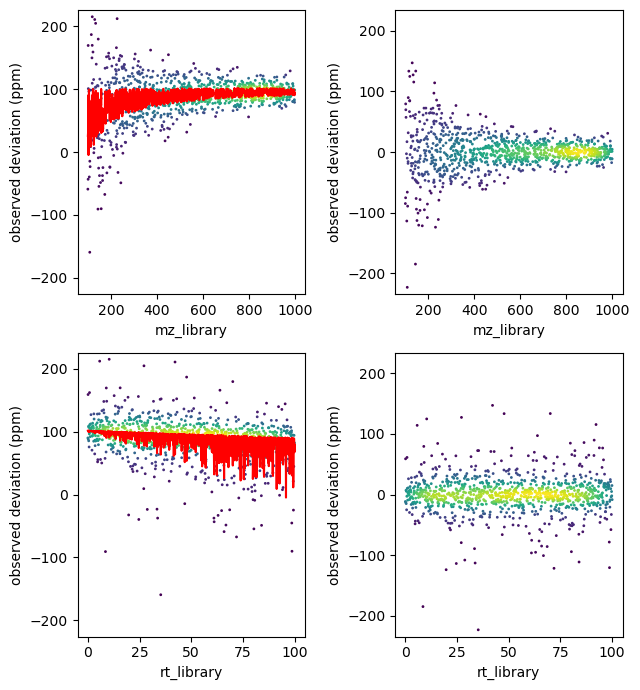

In [ ]:
# We will use a linear regression model to calibrate the mz values
mz_calibration = Calibration(
    name="mz_calibration",
    model=LinearRegression(),
    input_columns=["mz_library", "rt_library"],
    target_columns=["mz_observed"],
    output_columns=["mz_calibrated"],
    transform_deviation=1e6,
)

# The model is then fit to the data
mz_calibration.fit(mz_df, plot=True)

# Using the Calibration Manager to handle more complexe cases

In [ ]:
# initialize the calibration manager
calibration_manager = CalibrationManager()

# load the config from a dictionary. The dictionary could be loaded from a yaml file
calibration_manager.setup_estimator_groups(
    { "precursor" : {
            "mz" : {

                    "model": "LinearRegression",
                    "input_columns": ["mz_library"],
                    "target_columns": ["mz_observed"],
                    "output_columns": ["mz_calibrated"],
                    "transform_deviation": 1e6,
                },
               "rt": {
                    "model": "PolynomialRegression",
                    "model_args": {"degree": 3},
                    "input_columns": ["rt_library"],
                    "target_columns": ["rt_observed"],
                    "output_columns": ["rt_calibrated"],
                    "transform_deviation": None,
                },

        }
    }
)

In [ ]:
# The calibration manager contains a single estimator group with two calibration estimators
calibration_manager.estimator_groups

[{'name': 'mz_calibration',
  'estimators': [<Calibration mz, is_fitted: False>,
   <Calibration rt, is_fitted: False>]}]

In [ ]:
# lets create some test data with mz and rt values
mz_library = np.linspace(100, 1000, 1000)
mz_observed = (
    mz_library + np.random.normal(0, 0.001, 1000) + mz_library * 0.00001 + 0.005
)

rt_library = np.linspace(0, 100, 1000)
rt_observed = rt_library + np.random.normal(0, 0.5, 1000) + np.sin(rt_library * 0.05)

df = pd.DataFrame(
    {
        "mz_library": mz_library,
        "mz_observed": mz_observed,
        "rt_library": rt_library,
        "rt_observed": rt_observed,
    }
)

groups: ['mz_calibration']
estimators: ['mz', 'rt']


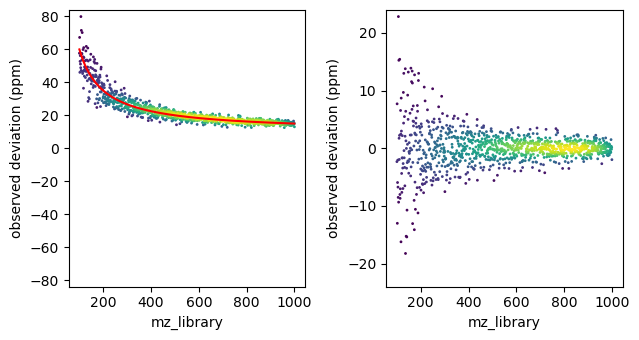

In [ ]:
# First, we will manually retrieve the mz estimators and fit them to the data
groups = list(calibration_manager.estimator_groups.keys())
print(f"groups: {groups}")
estimators = [estimator for estimator in list(calibration_manager.estimator_groups.values())[0]]
print(f"estimators for group 0: {estimators}")

# collect the estimator instance and fit it to the data
estimator = calibration_manager.get_estimator(groups[0], estimators[0])
estimator.fit(df, plot=True)
# predict the calibrated values
estimator.predict(df)

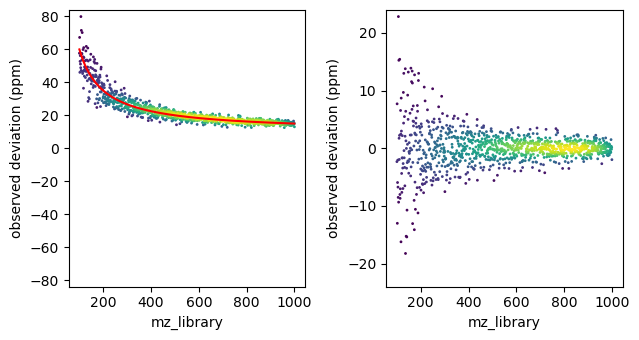

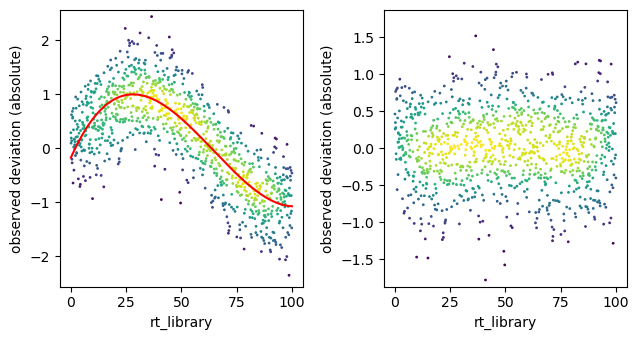

In [ ]:
# Now we will perform the calibration on the group level
# All estimators in the group will be fit to the data
calibration_manager.fit(df, groups[0], plot=True)

# we can then predict the calibrated values for all estimators in the group
calibration_manager.predict(df, groups[0])

In [ ]:
temp_path = path = os.path.join(tempfile.tempdir, "calibration.pkl")
calibration_manager._path = temp_path
calibration_manager.save()

calibration_manager_loaded = CalibrationManager(temp_path)
calibration_manager_loaded.load()

# We can also get the 99% percentile error of the model for all estimators in the group
for estimator in calibration_manager_loaded.estimator_groups["precursor"].values():
    ci = estimator.ci(df, 0.95)
    print(f" 95% CI for {estimator}: {ci}")

 95% CI for mz: 6.59260556160587
 95% CI for rt: 1.0030238017055564
